In [3]:
import numpy as np
import math
from matplotlib import pyplot as plt
from openmm import app
import openmm as mm
from openmm import unit
import sys
import os

In [36]:
def reload(fname,T = 50, gamma = 1/50, length = 1, dt = 0.1, skipSteps = 1, 
           f_pdb = "pdb", f_ff = "forcefield", srSize = 10):
    #fname = "{}fs_{}ps_{}K_{}ss.xyz".format(dt, length, T, skipSteps)
    totSteps = int(length*1000/(skipSteps * dt))
    print("totSteps", totSteps)

    a = np.loadtxt(fname)
    nParticles = a.shape[-1]//3
    a = a.reshape(totSteps, 3, nParticles)
    print(a.shape)

    return a


In [39]:
def euclidean_distance(r1,r2):
    d = np.sqrt(
        np.sum(
            np.square(r1-r2)
        )
    )
    return d

def find_closest_monomer(p_small,p_large):
    n_small = np.shape(p_small)[0]
    n_large = np.shape(p_large)[0]

    distance_matrix = np.zeros((n_small,n_large))

    # Calculate the distance from each unit of the smaller ring to each unit on 
    # the longer ring
    for i in range(n_small):
        for j in range(n_large):
            r1 = p_small[i,:]
            r2 = p_large[j,:]
            distance_matrix[i,j]= euclidean_distance(r1,r2)

    #Return the distance 
    closest_monomer_to_each_bead = np.argmin(distance_matrix,axis=1)
    return closest_monomer_to_each_bead

def calculate_circle_center_of_mass(ring):
    return np.mean(ring,axis=0)

def calculate_vector_magnitude(v):
    return np.sqrt(np.sum(np.square(v)))

def calculate_angular_displacement(fname):
   
    position_time_tensor =reload(fname)

    small_ring_carbon_indices=(0,20)
    large_ring_carbon_indices=(20,220)
    
    #Extract the small ring positions
    p_small = position_time_tensor[:,:,
                    small_ring_carbon_indices[0]:small_ring_carbon_indices[1]]
        
    #Extract the large ring positions
    p_large = position_time_tensor[:,:,
                    large_ring_carbon_indices[0]:large_ring_carbon_indices[1]]
    
    # Find the closest monomer to each bead for the initial position, 
    # transposing just to give the matrix the right shape 
    initial_closest_monomers_to_each_bead = find_closest_monomer(
        p_small[0,:,:].T,
        p_large[0,:,:].T
    )
    
    initial_index = int(np.mean(initial_closest_monomers_to_each_bead))
    
    nt = np.shape(position_time_tensor)[0]
    angular_displacement = np.zeros(nt)    

    # find the initial radius of the beads
    theta = 2*np.pi/p_large.shape[-1]
    
    for i in range(nt):
        # find the angle within the plane of r_s_CoM and r_l_CoM for each node
        small_center = calculate_circle_center_of_mass(p_small[i,:,:].T)
        #print(small_center)
        # find the current monomer index
        sm_mono_index = find_closest_monomer(np.array([small_center]), 
                                             p_large[i, :, :].T)
        
        # difference in index between init and current 
        delta = sm_mono_index - initial_index

        # angular distance according to the initial monomer geometry
        ang_disp = delta * theta

        angular_displacement[i] = ang_disp
        
    return angular_displacement

In [84]:
def runSim(T = 50, gamma = 1/50, length = 10, dt = 0.01, skipSteps = 1, f_pdb = "pdb", 
           f_ff = "forcefield", srSize = 20):
    """
    Function to run the openMM simulation (NVT) with given params and 
    pdb+forcefields

    Saves a xyz file of a compressed 3d array. See the function reload() to get 
    an idea of how to load and manipulate the output array (and format the file 
    name). The final array should have dims defined by 
    [n_timesteps, 3 (xyz), n_particles]

    parameters:
    T: int
        Temperature
    gamma: float
        Friction parameters for Langevin
    len: float
        Total length of the simulation in ps
    dt: float
        Size of the timesteps in ps
    f_pdb: str
        Name of the pdb file (excluding the file extension, which should 
        simply be .pdb)
    f_ff: str
        Name of the forcefield file (excluding the file extension, which should 
        simply be .xml)
    srSize: int
        Number of monomer units in the small ring
    """
    # set up strings
    # THE FOLLOWING FILE NAMES ARE PLACEHOLDERS: CHANGE WHEN POSSIBLE
    path = os.getcwd()
    pdbPath = os.path.join(path, "pdb_files/{}.pdb".format(f_pdb))
    forcefieldPath = os.path.join(path, "pdb_files/{}.xml".format(f_ff))

    # set up params
    kB = 1#1.38e-23
    beta = 1 # needs kb
    steps = int(length*1000/dt)
    indSteps = int(length*1000/(dt*skipSteps))

    # load external files for topo and PES
    pdb = app.PDBFile(pdbPath)
    topo = pdb.topology

    # identify atoms in topology
    particles = []
    # future update maybe: collect residues to identify number of atoms/chain
    # residues = []
    for atom in topo.atoms():
        particles.append(atom)
        # residues.append(atom.residue)

    # add bonds between the individual rings
    c1 = particles[0:srSize]
    c2 = particles[srSize:]
    numParticles = len(particles)
    # hy1 = particles[20:40]
    # hy2 = particles[40:60]

    # create arrays to store xyz coords in
    # format is timestep:xyz:particle#
    traj = np.zeros((indSteps, 3, numParticles))

    for i, C in enumerate(c1):
        topo.addBond(C, c1[i-1])
        # topo.addBond(C, hy1[i])
        # topo.addBond(C, hy2[i])
    
    for i, C in enumerate(c2):
        topo.addBond(C, c2[i-1])
        # topo.addBond(C, hy1[i])
        # topo.addBond(C, hy2[i])

    forcefield = app.ForceField(forcefieldPath)
    unmatched_residues = forcefield.getUnmatchedResidues(topo)
    print("unmatched residues\n", unmatched_residues)
    #nonbonded = app.NoCutoff
         
    system = forcefield.createSystem(topo,constraints=None)

    integrator = mm.LangevinIntegrator(T*unit.kelvin, gamma, dt)

    platform = mm.Platform.getPlatformByName('Reference')
    simulation = app.Simulation(topo, system, integrator, platform)
    #print(pdb.positions)
    simulation.context.setPositions(pdb.positions)
    current = simulation.context.getState(getPositions = True)
    #print(current)
    #simulation.context.computeVirtualSites()
    #simulation.context.setVelocitiesToTemperature(T)

    # equilibration step
    # simulation.step(1000)

    for step in range(10):
        simulation.step(skipSteps)
        # extract positions
        current = simulation.context.getState(getPositions = True)
        positions = np.array(current.getPositions()/unit.nanometer)
        traj[step, :, :] = positions.transpose()
        if step == 0:
            print(traj[step, :, :])

    # save the trajectory as an xyz file
    traj_r = traj.reshape(traj.shape[0], -1)
    print(traj_r.shape)
    np.savetxt("{}fs_{}ps_{}K_{}ss.xyz".format(dt, length, T, skipSteps), traj_r)
    return traj_r

## Suggestions 

1. Change temperature to inverse of KB
2. Add units back
3. Remove virtual sites? 
4. Does it work with just a small ring? 
5. Look at positions at step zeros





In [85]:
traj_r = runSim(
    T = 1, 
    gamma = 1/50, 
    length = 1, 
    dt = 0.1, 
    skipSteps = 1, 
    f_pdb = "combined_rings", 
    f_ff = "forcefield", 
    srSize = 10
)



unmatched residues
 []
[[ 1.53217028e+22  1.14410996e+22  5.53208246e+21 -2.84708772e+20
  -3.33588561e+21 -4.43789258e+21 -3.33588561e+21 -2.84708772e+20
   5.53208246e+21  1.14410996e+22 -2.86180031e+18 -3.00934304e+18
  -2.93503252e+18 -3.13770243e+18 -3.00963084e+18 -2.80164131e+18
  -2.59875150e+18 -2.47909095e+18 -3.20109257e+18 -2.84023127e+18
  -3.32359564e+18 -2.51698764e+18 -2.94224336e+18 -2.61670877e+18
  -2.73458196e+18 -2.37665734e+18 -2.41545767e+18 -2.09987350e+18
  -2.68980380e+18 -2.32501487e+18 -2.98145931e+18 -2.21513630e+18
  -2.13938291e+18 -2.01994805e+18 -2.25057288e+18 -2.06168890e+18
  -1.79722115e+18 -2.32566081e+18 -2.02414340e+18 -1.85557955e+18
  -8.12232105e+17 -1.92516315e+18 -1.50552235e+18 -2.27367442e+18
  -1.56003264e+18 -1.49033831e+18 -1.00086841e+18 -1.48392514e+18
  -7.93767955e+17 -1.88838441e+18  5.71209959e+17 -6.10283721e+17
   5.83566786e+17 -2.01590402e+18 -3.23461278e+18 -1.67210085e+19
  -4.58588836e+20 -1.93955525e+22 -1.99031396e+23  1.

In [73]:
print(traj_r)

[[ 7.66850971e+21  5.72626845e+21  2.76880635e+21 ...  6.95690893e+04
   6.95690834e+04  6.95690848e+04]
 [ 1.53216977e+22  1.14410958e+22  5.53208062e+21 ...  6.70917329e+04
   6.70917213e+04  6.70917247e+04]
 [ 2.29595947e+22  1.71445049e+22  8.28983387e+21 ...  2.93729736e+04
   2.93729549e+04  2.93729602e+04]
 ...
 [ 3.83809038e+24  2.86599831e+24  1.38578804e+24 ... -2.02605749e+07
  -2.02606451e+07 -2.02605370e+07]
 [ 3.83809038e+24  2.86599831e+24  1.38578804e+24 ... -2.02605749e+07
  -2.02606451e+07 -2.02605369e+07]
 [ 3.83809038e+24  2.86599831e+24  1.38578804e+24 ... -2.02605749e+07
  -2.02606451e+07 -2.02605369e+07]]


In [78]:
angs = calculate_angular_displacement("0.1fs_1ps_1K_1ss.xyz")
iters = np.arange(angs.shape[0])
print("shape of angles:", angs.shape)
print("shape of iters:", iters.shape)


totSteps 10000
(10000, 3, 210)
[ 1.87800557e+21 -8.74099599e+21  8.38860800e+05]
[ 3.75225888e+21 -1.74645275e+22  1.67542323e+06]
[ 5.62276742e+21 -2.61706293e+22 -3.36011909e+06]
[ 7.48953869e+21 -3.48593363e+22 -7.02714880e+03]
[ 9.35258015e+21 -4.35306833e+22  3.33333890e+06]
[ 1.12118992e+22 -5.21847049e+22 -6.73588563e+06]
[ 1.30675034e+22 -6.08214358e+22 -2.72853791e+04]
[ 1.49194001e+22 -6.94409105e+22 -8.05412154e+04]
[ 1.67675967e+22 -7.80431634e+22  6.61296809e+06]
[ 1.86121006e+22 -8.66282291e+22 -1.39074836e+05]
[ 2.04529191e+22 -9.51961417e+22 -1.35775905e+07]
[ 2.22900597e+22 -1.03746936e+23  1.32759163e+07]
[ 2.41235297e+22 -1.12280645e+23 -1.60110966e+05]
[ 2.59533365e+22 -1.20797304e+23 -1.75486837e+05]
[ 2.77794872e+22 -1.29296947e+23 -2.16400836e+05]
[ 2.96019893e+22 -1.37779608e+23 -1.36547578e+07]
[ 3.14208501e+22 -1.46245320e+23 -2.48383655e+05]
[ 3.32360768e+22 -1.54694117e+23 -1.36854696e+07]
[ 3.50476766e+22 -1.63126034e+23 -2.78976715e+05]
[ 3.68556569e+22 -1

[ 2.76250039e+23 -1.28577919e+24 -2.36695409e+06]
[ 2.77576097e+23 -1.29195120e+24 -2.37813862e+06]
[ 2.78899505e+23 -1.29811088e+24 -1.09763483e+08]
[ 2.80220269e+23 -1.30425825e+24 -2.40044069e+06]
[ 2.81538394e+23 -1.31039333e+24 -2.41155832e+06]
[ 2.82853886e+23 -1.31651616e+24 -2.42265373e+06]
[ 2.84166749e+23 -1.32262676e+24 -1.09807909e+08]
[ 2.85476989e+23 -1.32872514e+24 -2.44477809e+06]
[ 2.86784611e+23 -1.33481134e+24 -2.45580713e+06]
[ 2.88089620e+23 -1.34088538e+24 -2.46681414e+06]
[ 2.89392022e+23 -1.34694729e+24 -2.47779915e+06]
[ 2.90691822e+23 -1.35299708e+24 -1.09862945e+08]
[ 2.91989025e+23 -1.35903479e+24 -2.49970337e+06]
[ 2.93283636e+23 -1.36506043e+24 -2.51062267e+06]
[ 2.94575661e+23 -1.37107403e+24 -2.52152015e+06]
[ 2.95865104e+23 -1.37707562e+24 -2.53239586e+06]
[ 2.97151971e+23 -1.38306522e+24 -2.54324984e+06]
[ 2.98436266e+23 -1.38904285e+24 -2.55408213e+06]
[ 2.99717996e+23 -1.39500854e+24 -2.56489278e+06]
[ 3.00997164e+23 -1.40096230e+24 -2.57568183e+06]


[ 5.01241016e+23 -2.33297802e+24  2.10483741e+08]
[ 5.02117541e+23 -2.33705772e+24 -2.19020381e+08]
[ 5.02992315e+23 -2.34112928e+24 -2.19027759e+08]
[ 5.03865342e+23 -2.34519269e+24 -2.19035123e+08]
[ 5.04736624e+23 -2.34924799e+24 -4.29410682e+06]
[ 5.05606165e+23 -2.35329519e+24  2.10446924e+08]
[ 5.06473969e+23 -2.35733429e+24  2.10439604e+08]
[ 5.07340038e+23 -2.36136533e+24 -4.33812795e+08]
[ 5.08204378e+23 -2.36538832e+24 -4.32335533e+06]
[ 5.09066991e+23 -2.36940327e+24 -4.33063097e+06]
[ 5.09927880e+23 -2.37341019e+24  2.10410473e+08]
[ 5.10787049e+23 -2.37740911e+24 -4.34513867e+06]
[ 5.11644501e+23 -2.38140004e+24  4.25144359e+08]
[ 5.12500240e+23 -2.38538299e+24 -2.19107953e+08]
[ 5.13354269e+23 -2.38935799e+24  4.25129938e+08]
[ 5.14206593e+23 -2.39332505e+24 -4.37398055e+06]
[ 5.15057213e+23 -2.39728418e+24 -4.38115505e+06]
[ 5.15906133e+23 -2.40123540e+24  2.10360050e+08]
[ 5.16753358e+23 -2.40517872e+24 -4.39546105e+06]
[ 5.17598889e+23 -2.40911417e+24 -2.19150957e+08]


[ 6.25808529e+23 -2.91276551e+24  2.09433086e+08]
[ 6.26436169e+23 -2.91568680e+24  4.24176157e+08]
[ 6.27062554e+23 -2.91860225e+24 -4.34822585e+08]
[ 6.27687688e+23 -2.92151187e+24 -5.33112831e+06]
[ 6.28311572e+23 -2.92441568e+24 -4.34833120e+08]
[ 6.28934211e+23 -2.92731369e+24 -4.34838372e+08]
[ 6.29555605e+23 -2.93020591e+24  2.09401482e+08]
[ 6.30175757e+23 -2.93309235e+24  2.09396251e+08]
[ 6.30794671e+23 -2.93597303e+24 -4.34854064e+08]
[ 6.31412348e+23 -2.93884794e+24 -5.36254368e+06]
[ 6.32028791e+23 -2.94171712e+24 -5.36774302e+06]
[ 6.32644002e+23 -2.94458056e+24  2.09375433e+08]
[ 6.33257984e+23 -2.94743828e+24 -2.20126475e+08]
[ 6.33870739e+23 -2.95029029e+24 -5.38327880e+06]
[ 6.34482270e+23 -2.95313660e+24 -5.38843671e+06]
[ 6.35092579e+23 -2.95597723e+24  4.24103145e+08]
[ 6.35701669e+23 -2.95881218e+24  4.24098008e+08]
[ 6.36309542e+23 -2.96164146e+24 -2.20152213e+08]
[ 6.36916200e+23 -2.96446509e+24 -5.40896551e+06]
[ 6.37521646e+23 -2.96728309e+24  4.24082657e+08]


[ 7.63354286e+23 -3.55295898e+24 -6.47539817e+06]
[ 7.63707109e+23 -3.55460116e+24  4.23018356e+08]
[ 7.64059226e+23 -3.55624006e+24 -6.48134393e+06]
[ 7.64410641e+23 -3.55787569e+24 -6.48430791e+06]
[ 7.64761353e+23 -3.55950804e+24 -4.35983996e+08]
[ 7.65111364e+23 -3.56113714e+24 -4.35986948e+08]
[ 7.65460676e+23 -3.56276297e+24 -6.49316436e+06]
[ 7.65809290e+23 -3.56438557e+24 -4.35992834e+08]
[ 7.66157208e+23 -3.56600491e+24  4.22997690e+08]
[ 7.66504430e+23 -3.56762103e+24  8.52491491e+08]
[ 7.66850959e+23 -3.56923391e+24 -4.36001620e+08]
[ 7.67196795e+23 -3.57084357e+24 -6.50780752e+06]
[ 7.67541941e+23 -3.57245002e+24 -4.36007448e+08]
[ 7.67886396e+23 -3.57405326e+24 -4.36010354e+08]
[ 7.68230164e+23 -3.57565329e+24 -6.51652339e+06]
[ 7.68573245e+23 -3.57725012e+24 -6.51941708e+06]
[ 7.68915640e+23 -3.57884377e+24 -6.52230499e+06]
[ 7.69257351e+23 -3.58043423e+24 -6.52518712e+06]
[ 7.69598379e+23 -3.58202151e+24 -6.52806350e+06]
[ 7.69938726e+23 -3.58360563e+24  8.52462525e+08]


[ 8.26667123e+23 -3.84764249e+24  4.22487324e+08]
[ 8.26893447e+23 -3.84869589e+24  4.22485415e+08]
[ 8.27119318e+23 -3.84974718e+24  4.22483510e+08]
[ 8.27344738e+23 -3.85079638e+24 -7.01512077e+06]
[ 8.27569708e+23 -3.85184348e+24 -7.01701826e+06]
[ 8.27794228e+23 -3.85288849e+24 -4.36515642e+08]
[ 8.28018300e+23 -3.85393141e+24 -4.36517531e+08]
[ 8.28241924e+23 -3.85497224e+24 -7.02268801e+06]
[ 8.28465101e+23 -3.85601100e+24 -4.36521300e+08]
[ 8.28687832e+23 -3.85704768e+24 -4.36523179e+08]
[ 8.28910118e+23 -3.85808229e+24  4.22468406e+08]
[ 8.29131960e+23 -3.85911483e+24 -7.03019496e+06]
[ 8.29353359e+23 -3.86014531e+24 -7.03206233e+06]
[ 8.29574315e+23 -3.86117373e+24 -7.03392597e+06]
[ 8.29794830e+23 -3.86220010e+24  8.51957673e+08]
[ 8.30014905e+23 -3.86322441e+24  4.22459088e+08]
[ 8.30234539e+23 -3.86424668e+24 -7.03949458e+06]
[ 8.30453735e+23 -3.86526691e+24 -7.04134337e+06]
[ 8.30672493e+23 -3.86628509e+24 -7.04318846e+06]
[ 8.30890814e+23 -3.86730125e+24 -4.36541759e+08]


[ 8.67425298e+23 -4.03734748e+24 -4.36849907e+08]
[ 8.67570186e+23 -4.03802185e+24 -7.35439914e+06]
[ 8.67714786e+23 -4.03869488e+24 -7.35561875e+06]
[ 8.67859096e+23 -4.03936655e+24 -7.35683593e+06]
[ 8.68003118e+23 -4.04003689e+24  4.22138679e+08]
[ 8.68146852e+23 -4.04070589e+24 -4.36855993e+08]
[ 8.68290299e+23 -4.04137355e+24 -7.36047288e+06]
[ 8.68433459e+23 -4.04203987e+24 -4.36858410e+08]
[ 8.68576334e+23 -4.04270487e+24 -7.36288541e+06]
[ 8.68718923e+23 -4.04336853e+24 -4.36860818e+08]
[ 8.68861227e+23 -4.04403087e+24 -7.36528832e+06]
[ 8.69003246e+23 -4.04469189e+24 -7.36648617e+06]
[ 8.69144982e+23 -4.04535159e+24 -4.36864411e+08]
[ 8.69286435e+23 -4.04600997e+24 -4.36865604e+08]
[ 8.69427605e+23 -4.04666703e+24 -7.37006539e+06]
[ 8.69568493e+23 -4.04732278e+24 -7.37125370e+06]
[ 8.69709100e+23 -4.04797722e+24 -4.36869169e+08]
[ 8.69849425e+23 -4.04863035e+24  4.22123106e+08]
[ 8.69989471e+23 -4.04928218e+24  4.22121925e+08]
[ 8.70129236e+23 -4.04993270e+24 -7.37598324e+06]


[ 8.91137806e+23 -4.14771507e+24 -7.55317831e+06]
[ 8.91235317e+23 -4.14816892e+24 -8.66547460e+08]
[ 8.91332633e+23 -4.14862187e+24  4.21941908e+08]
[ 8.91429755e+23 -4.14907392e+24 -4.37052370e+08]
[ 8.91526683e+23 -4.14952506e+24 -4.37053188e+08]
[ 8.91623417e+23 -4.14997530e+24  4.21939455e+08]
[ 8.91719958e+23 -4.15042464e+24 -7.55808842e+06]
[ 8.91816306e+23 -4.15087308e+24 -8.66552360e+08]
[ 8.91912461e+23 -4.15132063e+24 -7.55971207e+06]
[ 8.92008424e+23 -4.15176728e+24 -4.37057251e+08]
[ 8.92104196e+23 -4.15221304e+24 -7.56132924e+06]
[ 8.92199776e+23 -4.15265791e+24 -4.37058865e+08]
[ 8.92295165e+23 -4.15310189e+24 -7.56293996e+06]
[ 8.92390364e+23 -4.15354498e+24  4.21932987e+08]
[ 8.92485372e+23 -4.15398719e+24  4.21932185e+08]
[ 8.92580191e+23 -4.15442851e+24 -4.37062074e+08]
[ 8.92674820e+23 -4.15486895e+24 -7.56614213e+06]
[ 8.92769260e+23 -4.15530851e+24  4.21929791e+08]
[ 8.92863512e+23 -4.15574720e+24 -7.56773363e+06]
[ 8.92957575e+23 -4.15618501e+24 -7.56852700e+06]


[ 9.07553118e+23 -4.22411856e+24 -4.37188361e+08]
[ 9.07617831e+23 -4.22441976e+24 -7.69217764e+06]
[ 9.07682415e+23 -4.22472036e+24 -8.66686182e+08]
[ 9.07746870e+23 -4.22502036e+24 -7.69326600e+06]
[ 9.07811196e+23 -4.22531976e+24  4.21802921e+08]
[ 9.07875394e+23 -4.22561856e+24  4.21802380e+08]
[ 9.07939463e+23 -4.22591676e+24  8.51298569e+08]
[ 9.08003404e+23 -4.22621437e+24 -7.69542972e+06]
[ 9.08067218e+23 -4.22651138e+24 -7.69596795e+06]
[ 9.08130904e+23 -4.22680780e+24 -4.37193235e+08]
[ 9.08194463e+23 -4.22710363e+24  8.51296418e+08]
[ 9.08257894e+23 -4.22739887e+24  8.51295883e+08]
[ 9.08321200e+23 -4.22769352e+24 -7.69811014e+06]
[ 9.08384378e+23 -4.22798758e+24 -4.37195373e+08]
[ 9.08447430e+23 -4.22828105e+24 -7.69917482e+06]
[ 9.08510357e+23 -4.22857393e+24  8.51293754e+08]
[ 9.08573158e+23 -4.22886623e+24 -7.70023525e+06]
[ 9.08635833e+23 -4.22915795e+24 -7.70076388e+06]
[ 9.08698383e+23 -4.22944908e+24 -7.70129145e+06]
[ 9.08760808e+23 -4.22973963e+24 -8.66695277e+08]


[ 9.26667952e+23 -4.31308671e+24  4.21643875e+08]
[ 9.26694474e+23 -4.31321015e+24 -4.37349808e+08]
[ 9.26720943e+23 -4.31333335e+24  4.21643428e+08]
[ 9.26747359e+23 -4.31345630e+24 -4.37350254e+08]
[ 9.26773722e+23 -4.31357901e+24 -7.85374644e+06]
[ 9.26800032e+23 -4.31370146e+24  4.21642761e+08]
[ 9.26826290e+23 -4.31382368e+24 -7.85418982e+06]
[ 9.26852496e+23 -4.31394565e+24  4.21642319e+08]
[ 9.26878649e+23 -4.31406738e+24 -7.85463143e+06]
[ 9.26904749e+23 -4.31418886e+24 -7.85485158e+06]
[ 9.26930798e+23 -4.31431010e+24  4.21641658e+08]
[ 9.26956795e+23 -4.31443110e+24 -4.37352020e+08]
[ 9.26982739e+23 -4.31455186e+24 -7.85550938e+06]
[ 9.27008632e+23 -4.31467237e+24  4.21641002e+08]
[ 9.27034473e+23 -4.31479265e+24  4.21640784e+08]
[ 9.27060263e+23 -4.31491268e+24 -7.85616324e+06]
[ 9.27086001e+23 -4.31503248e+24  4.21640349e+08]
[ 9.27111687e+23 -4.31515203e+24  4.21640133e+08]
[ 9.27137322e+23 -4.31527135e+24  8.51136646e+08]
[ 9.27162906e+23 -4.31539043e+24 -7.85702898e+06]


[ 9.30493955e+23 -4.33089447e+24 -7.88512443e+06]
[ 9.30512833e+23 -4.33098234e+24  4.21611446e+08]
[ 9.30531672e+23 -4.33107002e+24  4.21611287e+08]
[ 9.30550475e+23 -4.33115754e+24  8.51107858e+08]
[ 9.30569239e+23 -4.33124487e+24  8.51107700e+08]
[ 9.30587966e+23 -4.33133204e+24 -4.37382647e+08]
[ 9.30606656e+23 -4.33141903e+24  4.21610655e+08]
[ 9.30625308e+23 -4.33150584e+24 -7.88623231e+06]
[ 9.30643923e+23 -4.33159248e+24 -7.88638932e+06]
[ 9.30662501e+23 -4.33167895e+24  8.51106913e+08]
[ 9.30681041e+23 -4.33176525e+24 -4.37383432e+08]
[ 9.30699545e+23 -4.33185137e+24  4.21609871e+08]
[ 9.30718011e+23 -4.33193732e+24 -4.37383744e+08]
[ 9.30736441e+23 -4.33202310e+24 -7.88716966e+06]
[ 9.30754834e+23 -4.33210871e+24 -7.88732479e+06]
[ 9.30773190e+23 -4.33219415e+24 -4.37384209e+08]
[ 9.30791510e+23 -4.33227941e+24  4.21609095e+08]
[ 9.30809793e+23 -4.33236451e+24  4.21608941e+08]
[ 9.30828039e+23 -4.33244943e+24 -4.37384672e+08]
[ 9.30846249e+23 -4.33253419e+24  4.21608634e+08]


[ 9.33270775e+23 -4.34381891e+24 -7.90854523e+06]
[ 9.33284105e+23 -4.34388095e+24 -7.90865766e+06]
[ 9.33297407e+23 -4.34394287e+24 -7.90876986e+06]
[ 9.33310683e+23 -4.34400466e+24  4.21587848e+08]
[ 9.33323933e+23 -4.34406633e+24 -4.37405723e+08]
[ 9.33337156e+23 -4.34412788e+24 -4.37405835e+08]
[ 9.33350353e+23 -4.34418930e+24 -7.90921642e+06]
[ 9.33363523e+23 -4.34425060e+24 -4.37406057e+08]
[ 9.33376667e+23 -4.34431178e+24  8.51084021e+08]
[ 9.33389785e+23 -4.34437283e+24 -4.37406279e+08]
[ 9.33402876e+23 -4.34443377e+24  4.21587070e+08]
[ 9.33415942e+23 -4.34449458e+24 -7.90976962e+06]
[ 9.33428981e+23 -4.34455527e+24  4.21586850e+08]
[ 9.33441994e+23 -4.34461584e+24 -4.37406719e+08]
[ 9.33454982e+23 -4.34467628e+24 -7.91009889e+06]
[ 9.33467943e+23 -4.34473661e+24 -4.37406938e+08]
[ 9.33480878e+23 -4.34479682e+24 -4.37407047e+08]
[ 9.33493788e+23 -4.34485690e+24  8.51083033e+08]
[ 9.33506671e+23 -4.34491687e+24 -4.37407264e+08]
[ 9.33519529e+23 -4.34497672e+24 -7.91064331e+06]


[ 9.35871386e+23 -4.35592320e+24 -7.93047978e+06]
[ 9.35879519e+23 -4.35596106e+24 -7.93054838e+06]
[ 9.35887636e+23 -4.35599884e+24 -4.37427346e+08]
[ 9.35895737e+23 -4.35603654e+24  4.21566044e+08]
[ 9.35903821e+23 -4.35607417e+24 -4.37427483e+08]
[ 9.35911890e+23 -4.35611173e+24 -7.93082142e+06]
[ 9.35919942e+23 -4.35614921e+24 -4.37427619e+08]
[ 9.35927978e+23 -4.35618661e+24  4.21565772e+08]
[ 9.35935999e+23 -4.35622394e+24 -7.93102476e+06]
[ 9.35944003e+23 -4.35626119e+24 -4.37427822e+08]
[ 9.35951991e+23 -4.35629837e+24 -7.93115965e+06]
[ 9.35959963e+23 -4.35633548e+24  4.21565503e+08]
[ 9.35967920e+23 -4.35637251e+24 -7.93129400e+06]
[ 9.35975860e+23 -4.35640947e+24 -4.37428091e+08]
[ 9.35983785e+23 -4.35644635e+24 -7.93142781e+06]
[ 9.35991693e+23 -4.35648317e+24  4.21565235e+08]
[ 9.35999586e+23 -4.35651990e+24 -4.37428291e+08]
[ 9.36007463e+23 -4.35655657e+24 -8.66925087e+08]
[ 9.36015325e+23 -4.35659316e+24 -7.93169384e+06]
[ 9.36023170e+23 -4.35662967e+24 -8.66925219e+08]


[ 9.37245967e+23 -4.36232106e+24  4.21554656e+08]
[ 9.37251354e+23 -4.36234613e+24 -4.37438849e+08]
[ 9.37256730e+23 -4.36237115e+24 -8.66935624e+08]
[ 9.37262095e+23 -4.36239613e+24  4.21554520e+08]
[ 9.37267450e+23 -4.36242105e+24  4.21554475e+08]
[ 9.37272794e+23 -4.36244592e+24  4.21554430e+08]
[ 9.37278127e+23 -4.36247075e+24 -7.94234497e+06]
[ 9.37283449e+23 -4.36249552e+24  4.21554340e+08]
[ 9.37288761e+23 -4.36252024e+24  4.21554295e+08]
[ 9.37294063e+23 -4.36254492e+24 -7.94247938e+06]
[ 9.37299354e+23 -4.36256954e+24 -4.37439254e+08]
[ 9.37304634e+23 -4.36259412e+24  4.21554161e+08]
[ 9.37309903e+23 -4.36261865e+24 -7.94261298e+06]
[ 9.37315163e+23 -4.36264313e+24  4.21554072e+08]
[ 9.37320411e+23 -4.36266755e+24  4.21554028e+08]
[ 9.37325649e+23 -4.36269194e+24 -4.37439475e+08]
[ 9.37330877e+23 -4.36271627e+24 -4.37439519e+08]
[ 9.37336094e+23 -4.36274055e+24 -7.94283389e+06]
[ 9.37341301e+23 -4.36276478e+24  4.21553852e+08]
[ 9.37346497e+23 -4.36278897e+24 -7.94292163e+06]


[ 9.38156385e+23 -4.36655851e+24 -7.94975252e+06]
[ 9.38159953e+23 -4.36657512e+24  4.21546947e+08]
[ 9.38163514e+23 -4.36659169e+24 -8.66943272e+08]
[ 9.38167067e+23 -4.36660823e+24 -7.94984262e+06]
[ 9.38170614e+23 -4.36662474e+24 -7.94987253e+06]
[ 9.38174153e+23 -4.36664121e+24 -7.94990239e+06]
[ 9.38177686e+23 -4.36665766e+24 -7.94993218e+06]
[ 9.38181211e+23 -4.36667406e+24 -4.37446692e+08]
[ 9.38184729e+23 -4.36669044e+24 -4.37446721e+08]
[ 9.38188240e+23 -4.36670678e+24 -7.95002120e+06]
[ 9.38191745e+23 -4.36672309e+24 -7.95005076e+06]
[ 9.38195242e+23 -4.36673937e+24 -7.95008026e+06]
[ 9.38198732e+23 -4.36675561e+24  4.21546620e+08]
[ 9.38202215e+23 -4.36677183e+24  4.21546591e+08]
[ 9.38205692e+23 -4.36678801e+24 -4.37446898e+08]
[ 9.38209161e+23 -4.36680415e+24  4.21546532e+08]
[ 9.38212623e+23 -4.36682027e+24 -4.37446956e+08]
[ 9.38216079e+23 -4.36683635e+24 -7.95025600e+06]
[ 9.38219527e+23 -4.36685240e+24 -4.37447015e+08]
[ 9.38222969e+23 -4.36686842e+24  4.21546415e+08]


[ 9.38948262e+23 -4.37024423e+24 -7.95643158e+06]
[ 9.38950247e+23 -4.37025347e+24 -7.95644833e+06]
[ 9.38952229e+23 -4.37026269e+24 -4.37453195e+08]
[ 9.38954207e+23 -4.37027190e+24 -7.95648172e+06]
[ 9.38956181e+23 -4.37028109e+24 -4.37453228e+08]
[ 9.38958150e+23 -4.37029025e+24 -7.95651498e+06]
[ 9.38960116e+23 -4.37029940e+24 -4.37453261e+08]
[ 9.38962078e+23 -4.37030854e+24  4.21540181e+08]
[ 9.38964036e+23 -4.37031765e+24 -4.37453294e+08]
[ 9.38965991e+23 -4.37032675e+24  4.21540148e+08]
[ 9.38967941e+23 -4.37033582e+24 -4.37453327e+08]
[ 9.38969887e+23 -4.37034488e+24 -7.95661397e+06]
[ 9.38971830e+23 -4.37035392e+24 -7.95663036e+06]
[ 9.38973768e+23 -4.37036295e+24 -7.95664671e+06]
[ 9.38975703e+23 -4.37037195e+24 -4.37453393e+08]
[ 9.38977634e+23 -4.37038094e+24 -4.37453409e+08]
[ 9.38979561e+23 -4.37038991e+24 -4.37453425e+08]
[ 9.38981484e+23 -4.37039886e+24 -7.95671178e+06]
[ 9.38983403e+23 -4.37040779e+24 -4.37453458e+08]
[ 9.38985319e+23 -4.37041671e+24  4.21539985e+08]


[ 9.39226175e+23 -4.37153775e+24 -7.95877565e+06]
[ 9.39227606e+23 -4.37154441e+24  8.51034671e+08]
[ 9.39229033e+23 -4.37155105e+24  4.21537930e+08]
[ 9.39230458e+23 -4.37155768e+24 -7.95881177e+06]
[ 9.39231880e+23 -4.37156430e+24 -8.66952283e+08]
[ 9.39233299e+23 -4.37157091e+24  8.51034623e+08]
[ 9.39234715e+23 -4.37157750e+24 -7.95884768e+06]
[ 9.39236128e+23 -4.37158408e+24 -7.95885960e+06]
[ 9.39237539e+23 -4.37159064e+24  4.21537858e+08]
[ 9.39238947e+23 -4.37159719e+24  4.21537846e+08]
[ 9.39240352e+23 -4.37160373e+24 -4.37455625e+08]
[ 9.39241754e+23 -4.37161026e+24  4.21537823e+08]
[ 9.39243153e+23 -4.37161677e+24  8.51034540e+08]
[ 9.39244549e+23 -4.37162327e+24 -4.37455660e+08]
[ 9.39245943e+23 -4.37162976e+24 -7.95894239e+06]
[ 9.39247334e+23 -4.37163623e+24 -7.95895412e+06]
[ 9.39248722e+23 -4.37164269e+24 -7.95896583e+06]
[ 9.39250108e+23 -4.37164914e+24 -8.66952437e+08]
[ 9.39251490e+23 -4.37165558e+24  8.51034470e+08]
[ 9.39252870e+23 -4.37166200e+24  4.21537729e+08]


[ 9.39503505e+23 -4.37282856e+24  4.21535615e+08]
[ 9.39504382e+23 -4.37283263e+24  4.21535607e+08]
[ 9.39505256e+23 -4.37283670e+24 -4.37457859e+08]
[ 9.39506129e+23 -4.37284077e+24 -7.96113690e+06]
[ 9.39507000e+23 -4.37284482e+24  4.21535585e+08]
[ 9.39507869e+23 -4.37284887e+24 -4.37457881e+08]
[ 9.39508737e+23 -4.37285291e+24 -7.96115890e+06]
[ 9.39509603e+23 -4.37285694e+24  4.21535563e+08]
[ 9.39510467e+23 -4.37286096e+24 -7.96117349e+06]
[ 9.39511329e+23 -4.37286497e+24 -4.37457910e+08]
[ 9.39512190e+23 -4.37286898e+24 -4.37457918e+08]
[ 9.39513049e+23 -4.37287298e+24 -7.96119527e+06]
[ 9.39513906e+23 -4.37287697e+24 -4.37457932e+08]
[ 9.39514762e+23 -4.37288095e+24 -4.37457939e+08]
[ 9.39515616e+23 -4.37288492e+24 -8.66954676e+08]
[ 9.39516468e+23 -4.37288889e+24  4.21535505e+08]
[ 9.39517318e+23 -4.37289285e+24 -8.66954690e+08]
[ 9.39518167e+23 -4.37289680e+24  8.51032221e+08]
[ 9.39519014e+23 -4.37290074e+24  4.21535484e+08]
[ 9.39519859e+23 -4.37290467e+24 -7.96125271e+06]


[ 9.39699945e+23 -4.37374287e+24 -7.96277148e+06]
[ 9.39700429e+23 -4.37374512e+24 -7.96277556e+06]
[ 9.39700912e+23 -4.37374736e+24  4.21533950e+08]
[ 9.39701394e+23 -4.37374961e+24 -7.96278370e+06]
[ 9.39701875e+23 -4.37375185e+24 -7.96278775e+06]
[ 9.39702355e+23 -4.37375408e+24 -7.96279180e+06]
[ 9.39702834e+23 -4.37375631e+24 -4.37459525e+08]
[ 9.39703312e+23 -4.37375853e+24 -7.96279987e+06]
[ 9.39703789e+23 -4.37376076e+24  4.21533926e+08]
[ 9.39704265e+23 -4.37376297e+24 -7.96280791e+06]
[ 9.39704740e+23 -4.37376518e+24  4.21533918e+08]
[ 9.39705214e+23 -4.37376739e+24  4.21533914e+08]
[ 9.39705688e+23 -4.37376959e+24 -7.96281991e+06]
[ 9.39706160e+23 -4.37377179e+24 -7.96282390e+06]
[ 9.39706631e+23 -4.37377399e+24  4.21533902e+08]
[ 9.39707102e+23 -4.37377618e+24 -7.96283184e+06]
[ 9.39707571e+23 -4.37377836e+24 -7.96283580e+06]
[ 9.39708040e+23 -4.37378054e+24  8.51030619e+08]
[ 9.39708508e+23 -4.37378272e+24 -8.66956303e+08]
[ 9.39708974e+23 -4.37378489e+24 -4.37459577e+08]


[ 9.39794045e+23 -4.37418085e+24  4.21533164e+08]
[ 9.39794341e+23 -4.37418222e+24  4.21533162e+08]
[ 9.39794637e+23 -4.37418360e+24 -4.37460300e+08]
[ 9.39794931e+23 -4.37418497e+24 -7.96357264e+06]
[ 9.39795225e+23 -4.37418634e+24 -7.96357512e+06]
[ 9.39795519e+23 -4.37418770e+24 -7.96357760e+06]
[ 9.39795812e+23 -4.37418907e+24 -4.37460310e+08]
[ 9.39796104e+23 -4.37419043e+24  4.21533147e+08]
[ 9.39796395e+23 -4.37419178e+24 -4.37460315e+08]
[ 9.39796687e+23 -4.37419314e+24  4.21533142e+08]
[ 9.39796977e+23 -4.37419449e+24 -7.96358990e+06]
[ 9.39797267e+23 -4.37419584e+24 -7.96359235e+06]
[ 9.39797556e+23 -4.37419719e+24  4.21533135e+08]
[ 9.39797845e+23 -4.37419853e+24 -4.37460327e+08]
[ 9.39798133e+23 -4.37419987e+24 -4.37460329e+08]
[ 9.39798421e+23 -4.37420121e+24  4.21533128e+08]
[ 9.39798708e+23 -4.37420255e+24 -7.96360451e+06]
[ 9.39798995e+23 -4.37420388e+24 -4.37460337e+08]
[ 9.39799281e+23 -4.37420521e+24 -7.96360934e+06]
[ 9.39799566e+23 -4.37420654e+24 -7.96361175e+06]


[ 9.39840038e+23 -4.37439491e+24  8.51029506e+08]
[ 9.39840242e+23 -4.37439586e+24  8.51029504e+08]
[ 9.39840445e+23 -4.37439681e+24 -7.96395664e+06]
[ 9.39840648e+23 -4.37439775e+24 -7.96395836e+06]
[ 9.39840851e+23 -4.37439870e+24 -7.96396007e+06]
[ 9.39841053e+23 -4.37439964e+24 -4.37460691e+08]
[ 9.39841255e+23 -4.37440058e+24 -8.66957423e+08]
[ 9.39841457e+23 -4.37440152e+24  8.51029494e+08]
[ 9.39841658e+23 -4.37440245e+24  4.21532763e+08]
[ 9.39841858e+23 -4.37440339e+24  4.21532761e+08]
[ 9.39842059e+23 -4.37440432e+24 -4.37460700e+08]
[ 9.39842258e+23 -4.37440525e+24 -8.66957431e+08]
[ 9.39842458e+23 -4.37440618e+24 -4.37460703e+08]
[ 9.39842657e+23 -4.37440711e+24  4.21532754e+08]
[ 9.39842856e+23 -4.37440803e+24 -4.37460707e+08]
[ 9.39843054e+23 -4.37440895e+24  4.21532751e+08]
[ 9.39843252e+23 -4.37440987e+24  4.21532749e+08]
[ 9.39843449e+23 -4.37441079e+24  4.21532748e+08]
[ 9.39843647e+23 -4.37441171e+24 -7.96398366e+06]
[ 9.39843843e+23 -4.37441263e+24 -4.37460715e+08]


[ 9.39872998e+23 -4.37454832e+24 -4.37460961e+08]
[ 9.39873136e+23 -4.37454897e+24 -7.96423243e+06]
[ 9.39873274e+23 -4.37454961e+24 -7.96423359e+06]
[ 9.39873411e+23 -4.37455025e+24 -8.66957694e+08]
[ 9.39873548e+23 -4.37455089e+24 -7.96423591e+06]
[ 9.39873685e+23 -4.37455152e+24  4.21532493e+08]
[ 9.39873822e+23 -4.37455216e+24 -7.96423822e+06]
[ 9.39873958e+23 -4.37455279e+24  4.21532490e+08]
[ 9.39874094e+23 -4.37455343e+24  4.21532489e+08]
[ 9.39874230e+23 -4.37455406e+24 -4.37460971e+08]
[ 9.39874366e+23 -4.37455469e+24  4.21532487e+08]
[ 9.39874501e+23 -4.37455532e+24  8.51029215e+08]
[ 9.39874636e+23 -4.37455595e+24 -4.37460975e+08]
[ 9.39874771e+23 -4.37455658e+24 -4.37460976e+08]
[ 9.39874906e+23 -4.37455720e+24 -4.37460977e+08]
[ 9.39875040e+23 -4.37455783e+24 -7.96424849e+06]
[ 9.39875174e+23 -4.37455845e+24 -7.96424962e+06]
[ 9.39875308e+23 -4.37455907e+24 -4.37460980e+08]
[ 9.39875441e+23 -4.37455969e+24 -7.96425187e+06]
[ 9.39875574e+23 -4.37456031e+24 -8.66957712e+08]


[ 9.39894749e+23 -4.37464956e+24 -7.96441451e+06]
[ 9.39894843e+23 -4.37465000e+24 -7.96441530e+06]
[ 9.39894938e+23 -4.37465044e+24 -7.96441610e+06]
[ 9.39895032e+23 -4.37465088e+24 -7.96441689e+06]
[ 9.39895126e+23 -4.37465132e+24  4.21532312e+08]
[ 9.39895220e+23 -4.37465175e+24  8.51029041e+08]
[ 9.39895313e+23 -4.37465219e+24 -4.37461149e+08]
[ 9.39895407e+23 -4.37465262e+24  4.21532310e+08]
[ 9.39895500e+23 -4.37465306e+24 -7.96442084e+06]
[ 9.39895593e+23 -4.37465349e+24 -8.66957881e+08]
[ 9.39895686e+23 -4.37465392e+24 -4.37461152e+08]
[ 9.39895779e+23 -4.37465436e+24  4.21532306e+08]
[ 9.39895872e+23 -4.37465479e+24 -4.37461154e+08]
[ 9.39895964e+23 -4.37465522e+24  4.21532305e+08]
[ 9.39896056e+23 -4.37465565e+24 -7.96442552e+06]
[ 9.39896148e+23 -4.37465607e+24 -7.96442629e+06]
[ 9.39896240e+23 -4.37465650e+24 -7.96442707e+06]
[ 9.39896331e+23 -4.37465693e+24 -7.96442784e+06]
[ 9.39896423e+23 -4.37465735e+24  4.21532301e+08]
[ 9.39896514e+23 -4.37465778e+24 -7.96442938e+06]


[ 9.39909064e+23 -4.37471619e+24 -4.37461265e+08]
[ 9.39909130e+23 -4.37471650e+24 -4.37461265e+08]
[ 9.39909196e+23 -4.37471680e+24  4.21532193e+08]
[ 9.39909261e+23 -4.37471711e+24 -4.37461266e+08]
[ 9.39909327e+23 -4.37471741e+24 -7.96453727e+06]
[ 9.39909392e+23 -4.37471772e+24 -8.66957997e+08]
[ 9.39909458e+23 -4.37471802e+24 -7.96453837e+06]
[ 9.39909523e+23 -4.37471833e+24  4.21532191e+08]
[ 9.39909588e+23 -4.37471863e+24 -4.37461269e+08]
[ 9.39909653e+23 -4.37471893e+24 -4.37461270e+08]
[ 9.39909718e+23 -4.37471923e+24  4.21532189e+08]
[ 9.39909783e+23 -4.37471953e+24 -7.96454110e+06]
[ 9.39909847e+23 -4.37471983e+24 -7.96454164e+06]
[ 9.39909912e+23 -4.37472013e+24  8.51028917e+08]
[ 9.39909976e+23 -4.37472043e+24 -7.96454272e+06]
[ 9.39910040e+23 -4.37472073e+24 -8.66958002e+08]
[ 9.39910104e+23 -4.37472103e+24 -4.37461273e+08]
[ 9.39910168e+23 -4.37472133e+24 -4.37461274e+08]
[ 9.39910232e+23 -4.37472163e+24  4.21532185e+08]
[ 9.39910296e+23 -4.37472192e+24 -4.37461275e+08]


[ 9.39921203e+23 -4.37477269e+24 -4.37461367e+08]
[ 9.39921244e+23 -4.37477288e+24  4.21532092e+08]
[ 9.39921286e+23 -4.37477308e+24 -7.96463787e+06]
[ 9.39921328e+23 -4.37477327e+24 -8.66958097e+08]
[ 9.39921369e+23 -4.37477346e+24 -4.37461368e+08]
[ 9.39921411e+23 -4.37477366e+24 -7.96463892e+06]
[ 9.39921452e+23 -4.37477385e+24 -4.37461369e+08]
[ 9.39921493e+23 -4.37477404e+24 -7.96463961e+06]
[ 9.39921534e+23 -4.37477423e+24 -4.37461370e+08]
[ 9.39921575e+23 -4.37477442e+24 -8.66958100e+08]
[ 9.39921616e+23 -4.37477461e+24 -4.37461370e+08]
[ 9.39921657e+23 -4.37477480e+24 -7.96464100e+06]
[ 9.39921698e+23 -4.37477499e+24 -7.96464134e+06]
[ 9.39921739e+23 -4.37477518e+24 -7.96464168e+06]
[ 9.39921780e+23 -4.37477537e+24 -4.37461372e+08]
[ 9.39921820e+23 -4.37477556e+24 -7.96464237e+06]
[ 9.39921861e+23 -4.37477575e+24 -7.96464271e+06]
[ 9.39921901e+23 -4.37477594e+24 -7.96464305e+06]
[ 9.39921942e+23 -4.37477613e+24 -7.96464339e+06]
[ 9.39921982e+23 -4.37477631e+24 -4.37461373e+08]


[ 9.39928424e+23 -4.37480630e+24  4.21532032e+08]
[ 9.39928451e+23 -4.37480643e+24  8.51028761e+08]
[ 9.39928478e+23 -4.37480655e+24 -4.37461428e+08]
[ 9.39928506e+23 -4.37480668e+24 -7.96469867e+06]
[ 9.39928533e+23 -4.37480681e+24  4.21532031e+08]
[ 9.39928560e+23 -4.37480693e+24 -4.37461429e+08]
[ 9.39928587e+23 -4.37480706e+24 -7.96469935e+06]
[ 9.39928614e+23 -4.37480718e+24  4.21532030e+08]
[ 9.39928641e+23 -4.37480731e+24  4.21532030e+08]
[ 9.39928668e+23 -4.37480743e+24  4.21532030e+08]
[ 9.39928695e+23 -4.37480756e+24 -4.37461430e+08]
[ 9.39928721e+23 -4.37480768e+24 -7.96470048e+06]
[ 9.39928748e+23 -4.37480781e+24 -4.37461430e+08]
[ 9.39928775e+23 -4.37480793e+24 -7.96470093e+06]
[ 9.39928801e+23 -4.37480806e+24 -7.96470116e+06]
[ 9.39928828e+23 -4.37480818e+24 -7.96470138e+06]
[ 9.39928855e+23 -4.37480830e+24  4.21532028e+08]
[ 9.39928881e+23 -4.37480843e+24 -4.37461431e+08]
[ 9.39928907e+23 -4.37480855e+24 -4.37461432e+08]
[ 9.39928934e+23 -4.37480867e+24  4.21532027e+08]


[ 9.39933518e+23 -4.37483001e+24  4.21531989e+08]
[ 9.39933535e+23 -4.37483009e+24 -7.96474104e+06]
[ 9.39933552e+23 -4.37483017e+24 -4.37461471e+08]
[ 9.39933569e+23 -4.37483025e+24  4.21531988e+08]
[ 9.39933586e+23 -4.37483033e+24  4.21531988e+08]
[ 9.39933603e+23 -4.37483040e+24  8.51028718e+08]
[ 9.39933620e+23 -4.37483048e+24  4.21531988e+08]
[ 9.39933637e+23 -4.37483056e+24  4.21531988e+08]
[ 9.39933654e+23 -4.37483064e+24 -7.96474205e+06]
[ 9.39933671e+23 -4.37483072e+24  4.21531987e+08]
[ 9.39933688e+23 -4.37483080e+24 -7.96474234e+06]
[ 9.39933704e+23 -4.37483088e+24  4.21531987e+08]
[ 9.39933721e+23 -4.37483095e+24 -4.37461472e+08]
[ 9.39933738e+23 -4.37483103e+24 -7.96474276e+06]
[ 9.39933755e+23 -4.37483111e+24 -4.37461473e+08]
[ 9.39933771e+23 -4.37483119e+24 -7.96474305e+06]
[ 9.39933788e+23 -4.37483127e+24 -4.37461473e+08]
[ 9.39933805e+23 -4.37483134e+24 -4.37461473e+08]
[ 9.39933821e+23 -4.37483142e+24 -7.96474347e+06]
[ 9.39933838e+23 -4.37483150e+24 -4.37461473e+08]


[ 9.39936415e+23 -4.37484349e+24 -4.37461495e+08]
[ 9.39936427e+23 -4.37484355e+24 -8.66958225e+08]
[ 9.39936438e+23 -4.37484360e+24  4.21531964e+08]
[ 9.39936449e+23 -4.37484365e+24 -7.96476578e+06]
[ 9.39936461e+23 -4.37484371e+24 -4.37461495e+08]
[ 9.39936472e+23 -4.37484376e+24  4.21531964e+08]
[ 9.39936483e+23 -4.37484381e+24  4.21531964e+08]
[ 9.39936494e+23 -4.37484386e+24  4.21531963e+08]
[ 9.39936506e+23 -4.37484391e+24  4.21531963e+08]
[ 9.39936517e+23 -4.37484397e+24 -4.37461496e+08]
[ 9.39936528e+23 -4.37484402e+24 -4.37461496e+08]
[ 9.39936539e+23 -4.37484407e+24 -7.96476654e+06]
[ 9.39936550e+23 -4.37484412e+24 -4.37461496e+08]
[ 9.39936561e+23 -4.37484417e+24 -7.96476673e+06]
[ 9.39936572e+23 -4.37484422e+24  4.21531963e+08]
[ 9.39936583e+23 -4.37484428e+24 -7.96476692e+06]
[ 9.39936594e+23 -4.37484433e+24 -8.66958226e+08]
[ 9.39936605e+23 -4.37484438e+24 -7.96476711e+06]
[ 9.39936616e+23 -4.37484443e+24 -7.96476720e+06]
[ 9.39936627e+23 -4.37484448e+24 -7.96476729e+06]


[ 9.39938820e+23 -4.37485469e+24 -7.96478586e+06]
[ 9.39938826e+23 -4.37485472e+24 -4.37461516e+08]
[ 9.39938833e+23 -4.37485475e+24 -7.96478597e+06]
[ 9.39938839e+23 -4.37485478e+24  4.21531944e+08]
[ 9.39938846e+23 -4.37485481e+24 -4.37461516e+08]
[ 9.39938852e+23 -4.37485484e+24 -7.96478613e+06]
[ 9.39938859e+23 -4.37485487e+24 -7.96478619e+06]
[ 9.39938865e+23 -4.37485490e+24  8.51028673e+08]
[ 9.39938872e+23 -4.37485493e+24  4.21531943e+08]
[ 9.39938878e+23 -4.37485496e+24  4.21531943e+08]
[ 9.39938885e+23 -4.37485499e+24  4.21531943e+08]
[ 9.39938891e+23 -4.37485502e+24 -7.96478646e+06]
[ 9.39938898e+23 -4.37485505e+24 -7.96478651e+06]
[ 9.39938904e+23 -4.37485508e+24 -4.37461516e+08]
[ 9.39938910e+23 -4.37485511e+24  4.21531943e+08]
[ 9.39938917e+23 -4.37485514e+24  4.21531943e+08]
[ 9.39938923e+23 -4.37485517e+24  4.21531943e+08]
[ 9.39938929e+23 -4.37485520e+24 -4.37461516e+08]
[ 9.39938936e+23 -4.37485523e+24 -7.96478683e+06]
[ 9.39938942e+23 -4.37485525e+24 -7.96478689e+06]


[ 9.39939870e+23 -4.37485957e+24  4.21531935e+08]
[ 9.39939874e+23 -4.37485959e+24 -4.37461524e+08]
[ 9.39939879e+23 -4.37485961e+24  4.21531935e+08]
[ 9.39939883e+23 -4.37485963e+24  8.51028664e+08]
[ 9.39939888e+23 -4.37485966e+24  4.21531935e+08]
[ 9.39939892e+23 -4.37485968e+24 -4.37461524e+08]
[ 9.39939897e+23 -4.37485970e+24 -7.96479490e+06]
[ 9.39939901e+23 -4.37485972e+24 -4.37461525e+08]
[ 9.39939905e+23 -4.37485974e+24 -4.37461525e+08]
[ 9.39939910e+23 -4.37485976e+24  4.21531935e+08]
[ 9.39939914e+23 -4.37485978e+24 -4.37461525e+08]
[ 9.39939918e+23 -4.37485980e+24  4.21531935e+08]
[ 9.39939923e+23 -4.37485982e+24 -7.96479512e+06]
[ 9.39939927e+23 -4.37485984e+24  4.21531934e+08]
[ 9.39939931e+23 -4.37485986e+24 -4.37461525e+08]
[ 9.39939936e+23 -4.37485988e+24 -7.96479523e+06]
[ 9.39939940e+23 -4.37485990e+24 -4.37461525e+08]
[ 9.39939944e+23 -4.37485992e+24 -4.37461525e+08]
[ 9.39939949e+23 -4.37485994e+24  4.21531934e+08]
[ 9.39939953e+23 -4.37485996e+24 -7.96479537e+06]


[ 9.39940700e+23 -4.37486344e+24 -8.66958261e+08]
[ 9.39940703e+23 -4.37486345e+24  4.21531928e+08]
[ 9.39940706e+23 -4.37486346e+24  4.21531928e+08]
[ 9.39940709e+23 -4.37486348e+24 -7.96480173e+06]
[ 9.39940711e+23 -4.37486349e+24 -7.96480175e+06]
[ 9.39940714e+23 -4.37486350e+24 -7.96480177e+06]
[ 9.39940717e+23 -4.37486352e+24 -4.37461531e+08]
[ 9.39940720e+23 -4.37486353e+24 -7.96480182e+06]
[ 9.39940722e+23 -4.37486354e+24 -7.96480184e+06]
[ 9.39940725e+23 -4.37486355e+24  4.21531928e+08]
[ 9.39940728e+23 -4.37486357e+24  8.51028657e+08]
[ 9.39940731e+23 -4.37486358e+24 -4.37461532e+08]
[ 9.39940733e+23 -4.37486359e+24  8.51028657e+08]
[ 9.39940736e+23 -4.37486360e+24 -4.37461532e+08]
[ 9.39940739e+23 -4.37486362e+24 -7.96480198e+06]
[ 9.39940742e+23 -4.37486363e+24 -8.66958261e+08]
[ 9.39940744e+23 -4.37486364e+24 -4.37461532e+08]
[ 9.39940747e+23 -4.37486366e+24  4.21531928e+08]
[ 9.39940750e+23 -4.37486367e+24  4.21531928e+08]
[ 9.39940752e+23 -4.37486368e+24  4.21531928e+08]


[ 9.39941519e+23 -4.37486725e+24  4.21531921e+08]
[ 9.39941520e+23 -4.37486725e+24 -8.66958268e+08]
[ 9.39941521e+23 -4.37486726e+24  4.21531921e+08]
[ 9.39941522e+23 -4.37486726e+24 -7.96480853e+06]
[ 9.39941523e+23 -4.37486727e+24 -7.96480854e+06]
[ 9.39941525e+23 -4.37486727e+24 -4.37461538e+08]
[ 9.39941526e+23 -4.37486728e+24 -4.37461538e+08]
[ 9.39941527e+23 -4.37486728e+24 -4.37461538e+08]
[ 9.39941528e+23 -4.37486729e+24  4.21531921e+08]
[ 9.39941529e+23 -4.37486730e+24  8.51028651e+08]
[ 9.39941530e+23 -4.37486730e+24  4.21531921e+08]
[ 9.39941531e+23 -4.37486731e+24 -7.96480861e+06]
[ 9.39941533e+23 -4.37486731e+24 -7.96480862e+06]
[ 9.39941534e+23 -4.37486732e+24 -7.96480863e+06]
[ 9.39941535e+23 -4.37486732e+24 -7.96480864e+06]
[ 9.39941536e+23 -4.37486733e+24 -7.96480865e+06]
[ 9.39941537e+23 -4.37486733e+24 -7.96480866e+06]
[ 9.39941538e+23 -4.37486734e+24  8.51028651e+08]
[ 9.39941539e+23 -4.37486734e+24 -4.37461538e+08]
[ 9.39941540e+23 -4.37486735e+24 -7.96480869e+06]


[ 9.39941736e+23 -4.37486826e+24 -4.37461540e+08]
[ 9.39941737e+23 -4.37486826e+24 -7.96481041e+06]
[ 9.39941738e+23 -4.37486827e+24 -4.37461540e+08]
[ 9.39941739e+23 -4.37486827e+24 -7.96481043e+06]
[ 9.39941739e+23 -4.37486827e+24  4.21531919e+08]
[ 9.39941740e+23 -4.37486828e+24 -7.96481044e+06]
[ 9.39941741e+23 -4.37486828e+24  8.51028649e+08]
[ 9.39941741e+23 -4.37486828e+24  4.21531919e+08]
[ 9.39941742e+23 -4.37486829e+24 -7.96481045e+06]
[ 9.39941743e+23 -4.37486829e+24 -7.96481046e+06]
[ 9.39941744e+23 -4.37486829e+24  4.21531919e+08]
[ 9.39941744e+23 -4.37486830e+24 -7.96481047e+06]
[ 9.39941745e+23 -4.37486830e+24  4.21531919e+08]
[ 9.39941746e+23 -4.37486830e+24 -4.37461540e+08]
[ 9.39941746e+23 -4.37486831e+24  4.21531919e+08]
[ 9.39941747e+23 -4.37486831e+24  4.21531919e+08]
[ 9.39941748e+23 -4.37486831e+24 -7.96481050e+06]
[ 9.39941748e+23 -4.37486832e+24 -7.96481050e+06]
[ 9.39941749e+23 -4.37486832e+24 -4.37461540e+08]
[ 9.39941750e+23 -4.37486832e+24 -4.37461540e+08]


[ 9.39941874e+23 -4.37486890e+24 -7.96481168e+06]
[ 9.39941874e+23 -4.37486890e+24 -7.96481168e+06]
[ 9.39941875e+23 -4.37486890e+24  4.21531918e+08]
[ 9.39941875e+23 -4.37486891e+24 -7.96481169e+06]
[ 9.39941875e+23 -4.37486891e+24  4.21531918e+08]
[ 9.39941876e+23 -4.37486891e+24  4.21531918e+08]
[ 9.39941876e+23 -4.37486891e+24 -4.37461541e+08]
[ 9.39941877e+23 -4.37486891e+24 -4.37461541e+08]
[ 9.39941877e+23 -4.37486892e+24  8.51028647e+08]
[ 9.39941878e+23 -4.37486892e+24 -4.37461541e+08]
[ 9.39941878e+23 -4.37486892e+24 -7.96481172e+06]
[ 9.39941879e+23 -4.37486892e+24 -4.37461541e+08]
[ 9.39941879e+23 -4.37486892e+24  4.21531918e+08]
[ 9.39941879e+23 -4.37486893e+24  4.21531918e+08]
[ 9.39941880e+23 -4.37486893e+24 -4.37461541e+08]
[ 9.39941880e+23 -4.37486893e+24  8.51028647e+08]
[ 9.39941881e+23 -4.37486893e+24 -7.96481175e+06]
[ 9.39941881e+23 -4.37486893e+24  4.21531918e+08]
[ 9.39941882e+23 -4.37486894e+24 -8.66958271e+08]
[ 9.39941882e+23 -4.37486894e+24 -7.96481176e+06]


[ 9.39941987e+23 -4.37486943e+24 -4.37461542e+08]
[ 9.39941987e+23 -4.37486943e+24  4.21531917e+08]
[ 9.39941987e+23 -4.37486943e+24 -4.37461542e+08]
[ 9.39941987e+23 -4.37486943e+24 -7.96481250e+06]
[ 9.39941988e+23 -4.37486943e+24 -7.96481250e+06]
[ 9.39941988e+23 -4.37486943e+24 -4.37461542e+08]
[ 9.39941988e+23 -4.37486943e+24 -7.96481250e+06]
[ 9.39941988e+23 -4.37486943e+24 -4.37461542e+08]
[ 9.39941988e+23 -4.37486943e+24  4.21531917e+08]
[ 9.39941989e+23 -4.37486943e+24 -7.96481250e+06]
[ 9.39941989e+23 -4.37486944e+24 -4.37461542e+08]
[ 9.39941989e+23 -4.37486944e+24 -8.66958272e+08]
[ 9.39941989e+23 -4.37486944e+24 -8.66958272e+08]
[ 9.39941990e+23 -4.37486944e+24 -4.37461542e+08]
[ 9.39941990e+23 -4.37486944e+24 -7.96481251e+06]
[ 9.39941990e+23 -4.37486944e+24  4.21531917e+08]
[ 9.39941990e+23 -4.37486944e+24 -7.96481251e+06]
[ 9.39941990e+23 -4.37486944e+24 -7.96481251e+06]
[ 9.39941991e+23 -4.37486944e+24 -7.96481251e+06]
[ 9.39941991e+23 -4.37486944e+24 -4.37461542e+08]


[ 9.39942034e+23 -4.37486965e+24 -4.37461542e+08]
[ 9.39942034e+23 -4.37486965e+24 -7.96481261e+06]
[ 9.39942035e+23 -4.37486965e+24 -8.66958272e+08]
[ 9.39942035e+23 -4.37486965e+24  4.21531917e+08]
[ 9.39942035e+23 -4.37486965e+24 -8.66958272e+08]
[ 9.39942035e+23 -4.37486965e+24 -7.96481261e+06]
[ 9.39942035e+23 -4.37486965e+24 -8.66958272e+08]
[ 9.39942035e+23 -4.37486965e+24  8.51028647e+08]
[ 9.39942035e+23 -4.37486965e+24 -4.37461542e+08]
[ 9.39942035e+23 -4.37486965e+24  4.21531917e+08]
[ 9.39942036e+23 -4.37486965e+24 -7.96481261e+06]
[ 9.39942036e+23 -4.37486965e+24  4.21531917e+08]
[ 9.39942036e+23 -4.37486965e+24 -7.96481261e+06]
[ 9.39942036e+23 -4.37486965e+24 -7.96481261e+06]
[ 9.39942036e+23 -4.37486966e+24 -7.96481261e+06]
[ 9.39942036e+23 -4.37486966e+24  4.21531917e+08]
[ 9.39942036e+23 -4.37486966e+24  4.21531917e+08]
[ 9.39942036e+23 -4.37486966e+24 -7.96481260e+06]
[ 9.39942037e+23 -4.37486966e+24  4.21531917e+08]
[ 9.39942037e+23 -4.37486966e+24 -7.96481260e+06]


[ 9.39942056e+23 -4.37486975e+24  4.21531917e+08]
[ 9.39942056e+23 -4.37486975e+24 -7.96481262e+06]
[ 9.39942056e+23 -4.37486975e+24 -7.96481262e+06]
[ 9.39942056e+23 -4.37486975e+24 -8.66958272e+08]
[ 9.39942056e+23 -4.37486975e+24  4.21531917e+08]
[ 9.39942056e+23 -4.37486975e+24 -7.96481262e+06]
[ 9.39942056e+23 -4.37486975e+24  4.21531917e+08]
[ 9.39942057e+23 -4.37486975e+24 -4.37461542e+08]
[ 9.39942057e+23 -4.37486975e+24  4.21531917e+08]
[ 9.39942057e+23 -4.37486975e+24 -4.37461542e+08]
[ 9.39942057e+23 -4.37486975e+24 -4.37461542e+08]
[ 9.39942057e+23 -4.37486975e+24 -4.37461542e+08]
[ 9.39942057e+23 -4.37486975e+24 -7.96481263e+06]
[ 9.39942057e+23 -4.37486975e+24  4.21531917e+08]
[ 9.39942057e+23 -4.37486975e+24 -4.37461542e+08]
[ 9.39942057e+23 -4.37486975e+24  8.51028647e+08]
[ 9.39942057e+23 -4.37486975e+24 -8.66958272e+08]
[ 9.39942057e+23 -4.37486975e+24  4.21531917e+08]
[ 9.39942057e+23 -4.37486975e+24 -4.37461542e+08]
[ 9.39942058e+23 -4.37486976e+24 -7.96481263e+06]


[ 9.39942069e+23 -4.37486981e+24 -7.96481273e+06]
[ 9.39942069e+23 -4.37486981e+24  4.21531917e+08]
[ 9.39942069e+23 -4.37486981e+24 -7.96481273e+06]
[ 9.39942069e+23 -4.37486981e+24 -7.96481274e+06]
[ 9.39942069e+23 -4.37486981e+24 -4.37461542e+08]
[ 9.39942069e+23 -4.37486981e+24  8.51028646e+08]
[ 9.39942069e+23 -4.37486981e+24  8.51028646e+08]
[ 9.39942069e+23 -4.37486981e+24 -4.37461542e+08]
[ 9.39942069e+23 -4.37486981e+24 -7.96481274e+06]
[ 9.39942069e+23 -4.37486981e+24 -8.66958272e+08]
[ 9.39942070e+23 -4.37486981e+24  4.21531917e+08]
[ 9.39942070e+23 -4.37486981e+24 -4.37461542e+08]
[ 9.39942070e+23 -4.37486981e+24  4.21531917e+08]
[ 9.39942070e+23 -4.37486981e+24 -4.37461542e+08]
[ 9.39942070e+23 -4.37486981e+24 -7.96481274e+06]
[ 9.39942070e+23 -4.37486981e+24 -4.37461542e+08]
[ 9.39942070e+23 -4.37486981e+24 -4.37461542e+08]
[ 9.39942070e+23 -4.37486981e+24 -8.66958272e+08]
[ 9.39942070e+23 -4.37486981e+24 -4.37461542e+08]
[ 9.39942070e+23 -4.37486981e+24 -4.37461542e+08]


[ 9.39942084e+23 -4.37486988e+24  4.21531917e+08]
[ 9.39942084e+23 -4.37486988e+24 -4.37461542e+08]
[ 9.39942084e+23 -4.37486988e+24 -4.37461542e+08]
[ 9.39942084e+23 -4.37486988e+24  8.51028647e+08]
[ 9.39942084e+23 -4.37486988e+24 -7.96481258e+06]
[ 9.39942084e+23 -4.37486988e+24 -4.37461542e+08]
[ 9.39942084e+23 -4.37486988e+24 -4.37461542e+08]
[ 9.39942084e+23 -4.37486988e+24  8.51028647e+08]
[ 9.39942084e+23 -4.37486988e+24 -4.37461542e+08]
[ 9.39942084e+23 -4.37486988e+24 -7.96481257e+06]
[ 9.39942084e+23 -4.37486988e+24 -7.96481257e+06]
[ 9.39942084e+23 -4.37486988e+24 -8.66958272e+08]
[ 9.39942084e+23 -4.37486988e+24  4.21531917e+08]
[ 9.39942084e+23 -4.37486988e+24 -4.37461542e+08]
[ 9.39942084e+23 -4.37486988e+24  4.21531917e+08]
[ 9.39942084e+23 -4.37486988e+24 -7.96481257e+06]
[ 9.39942084e+23 -4.37486988e+24  8.51028647e+08]
[ 9.39942084e+23 -4.37486988e+24 -4.37461542e+08]
[ 9.39942084e+23 -4.37486988e+24  4.21531917e+08]
[ 9.39942084e+23 -4.37486988e+24  8.51028647e+08]


[ 9.39942089e+23 -4.37486990e+24 -4.37461542e+08]
[ 9.39942089e+23 -4.37486990e+24 -7.96481253e+06]
[ 9.39942089e+23 -4.37486990e+24 -7.96481253e+06]
[ 9.39942089e+23 -4.37486990e+24 -7.96481253e+06]
[ 9.39942089e+23 -4.37486990e+24 -4.37461542e+08]
[ 9.39942089e+23 -4.37486990e+24 -4.37461542e+08]
[ 9.39942089e+23 -4.37486990e+24 -4.37461542e+08]
[ 9.39942090e+23 -4.37486990e+24 -7.96481253e+06]
[ 9.39942090e+23 -4.37486990e+24  4.21531917e+08]
[ 9.39942090e+23 -4.37486990e+24 -4.37461542e+08]
[ 9.39942090e+23 -4.37486990e+24  8.51028647e+08]
[ 9.39942090e+23 -4.37486990e+24 -7.96481253e+06]
[ 9.39942090e+23 -4.37486990e+24 -7.96481253e+06]
[ 9.39942090e+23 -4.37486990e+24  4.21531917e+08]
[ 9.39942090e+23 -4.37486990e+24 -8.66958272e+08]
[ 9.39942090e+23 -4.37486990e+24 -4.37461542e+08]
[ 9.39942090e+23 -4.37486990e+24  4.21531917e+08]
[ 9.39942090e+23 -4.37486990e+24  8.51028647e+08]
[ 9.39942090e+23 -4.37486990e+24 -8.66958272e+08]
[ 9.39942090e+23 -4.37486990e+24 -7.96481253e+06]


[ 9.39942093e+23 -4.37486992e+24 -4.37461542e+08]
[ 9.39942093e+23 -4.37486992e+24 -7.96481257e+06]
[ 9.39942093e+23 -4.37486992e+24 -7.96481257e+06]
[ 9.39942093e+23 -4.37486992e+24 -7.96481257e+06]
[ 9.39942093e+23 -4.37486992e+24 -8.66958272e+08]
[ 9.39942093e+23 -4.37486992e+24 -7.96481257e+06]
[ 9.39942093e+23 -4.37486992e+24  4.21531917e+08]
[ 9.39942093e+23 -4.37486992e+24 -4.37461542e+08]
[ 9.39942093e+23 -4.37486992e+24 -7.96481257e+06]
[ 9.39942093e+23 -4.37486992e+24 -4.37461542e+08]
[ 9.39942093e+23 -4.37486992e+24 -8.66958272e+08]
[ 9.39942093e+23 -4.37486992e+24 -8.66958272e+08]
[ 9.39942093e+23 -4.37486992e+24 -7.96481257e+06]
[ 9.39942093e+23 -4.37486992e+24  4.21531917e+08]
[ 9.39942093e+23 -4.37486992e+24 -7.96481257e+06]
[ 9.39942093e+23 -4.37486992e+24  4.21531917e+08]
[ 9.39942093e+23 -4.37486992e+24 -4.37461542e+08]
[ 9.39942093e+23 -4.37486992e+24  8.51028647e+08]
[ 9.39942093e+23 -4.37486992e+24 -7.96481257e+06]
[ 9.39942093e+23 -4.37486992e+24  8.51028647e+08]


[ 9.39942095e+23 -4.37486993e+24 -7.96481259e+06]
[ 9.39942095e+23 -4.37486993e+24 -7.96481259e+06]
[ 9.39942095e+23 -4.37486993e+24 -4.37461542e+08]
[ 9.39942095e+23 -4.37486993e+24  4.21531917e+08]
[ 9.39942095e+23 -4.37486993e+24 -7.96481259e+06]
[ 9.39942095e+23 -4.37486993e+24 -7.96481259e+06]
[ 9.39942095e+23 -4.37486993e+24 -4.37461542e+08]
[ 9.39942095e+23 -4.37486993e+24  4.21531917e+08]
[ 9.39942095e+23 -4.37486993e+24 -4.37461542e+08]
[ 9.39942095e+23 -4.37486993e+24 -7.96481259e+06]
[ 9.39942095e+23 -4.37486993e+24 -7.96481259e+06]
[ 9.39942095e+23 -4.37486993e+24 -8.66958272e+08]
[ 9.39942095e+23 -4.37486993e+24 -7.96481259e+06]
[ 9.39942095e+23 -4.37486993e+24  4.21531917e+08]
[ 9.39942095e+23 -4.37486993e+24  8.51028647e+08]
[ 9.39942095e+23 -4.37486993e+24  4.21531917e+08]
[ 9.39942095e+23 -4.37486993e+24 -7.96481259e+06]
[ 9.39942095e+23 -4.37486993e+24 -7.96481259e+06]
[ 9.39942095e+23 -4.37486993e+24 -4.37461542e+08]
[ 9.39942095e+23 -4.37486993e+24 -7.96481259e+06]


[ 9.39942097e+23 -4.37486994e+24  4.21531917e+08]
[ 9.39942097e+23 -4.37486994e+24 -4.37461542e+08]
[ 9.39942097e+23 -4.37486994e+24  4.21531917e+08]
[ 9.39942097e+23 -4.37486994e+24  8.51028646e+08]
[ 9.39942097e+23 -4.37486994e+24 -7.96481271e+06]
[ 9.39942097e+23 -4.37486994e+24 -4.37461542e+08]
[ 9.39942097e+23 -4.37486994e+24 -7.96481271e+06]
[ 9.39942097e+23 -4.37486994e+24 -7.96481271e+06]
[ 9.39942097e+23 -4.37486994e+24 -4.37461542e+08]
[ 9.39942097e+23 -4.37486994e+24  4.21531917e+08]
[ 9.39942097e+23 -4.37486994e+24 -7.96481272e+06]
[ 9.39942097e+23 -4.37486994e+24 -7.96481272e+06]
[ 9.39942097e+23 -4.37486994e+24 -7.96481272e+06]
[ 9.39942097e+23 -4.37486994e+24 -7.96481272e+06]
[ 9.39942097e+23 -4.37486994e+24 -7.96481272e+06]
[ 9.39942097e+23 -4.37486994e+24 -7.96481272e+06]
[ 9.39942097e+23 -4.37486994e+24  4.21531917e+08]
[ 9.39942097e+23 -4.37486994e+24 -7.96481273e+06]
[ 9.39942097e+23 -4.37486994e+24 -4.37461542e+08]
[ 9.39942097e+23 -4.37486994e+24  4.21531917e+08]


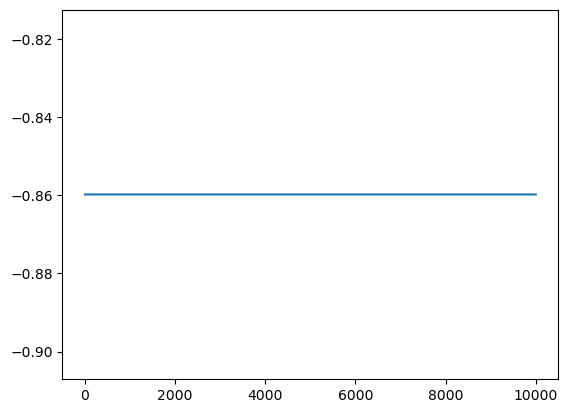

In [80]:
plt.figure()
plt.plot(iters, angs)
